In [ ]:
# I finally chose no class conditioning, as the class is not localy deductible

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import contextlib
import os
import librosa
import os
import torch
import torchaudio

DATA_PATH = r'C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2'

# Explore

In [15]:
def get_wav_files(data_path):
    wav_files = []
    
    # Traverse the directory tree
    for root, dirs, files in os.walk(data_path):
        
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    
    return wav_files


In [16]:
len(get_wav_files(DATA_PATH))

433

In [17]:
wav_paths = get_wav_files(DATA_PATH)

In [26]:
durations = []
sample_rates = []

for path in wav_paths:
    with contextlib.closing(wave.open(path, 'r')) as wav_file:
        frames = wav_file.getnframes()  # number of frames
        rate = wav_file.getframerate()  # sample rate
        duration = frames / float(rate)  # length in seconds
        
        durations.append(duration)
        sample_rates.append(rate)

sample_rates = np.array(sample_rates)
durations = np.array(durations)

In [27]:
sample_rates.mean()

44100.0

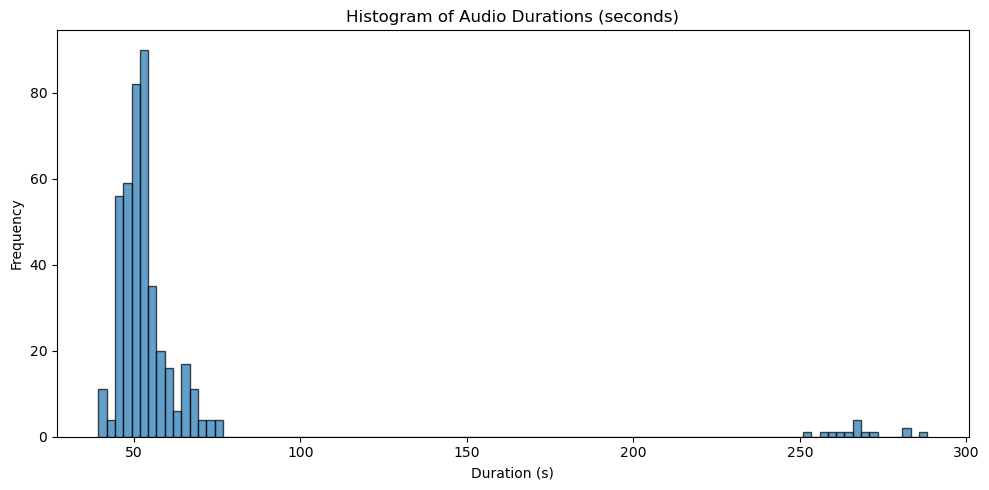

In [29]:
plt.figure(figsize=(10, 5))

plt.hist(durations, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of Audio Durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
# Print the names of files with duration more than 100 seconds
for path, duration in zip(wav_paths, durations):
    if duration > 100:
        print(path)

C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-1.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-4.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-3.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-4.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-5.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-6.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VN1-NR\VN1-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Mus

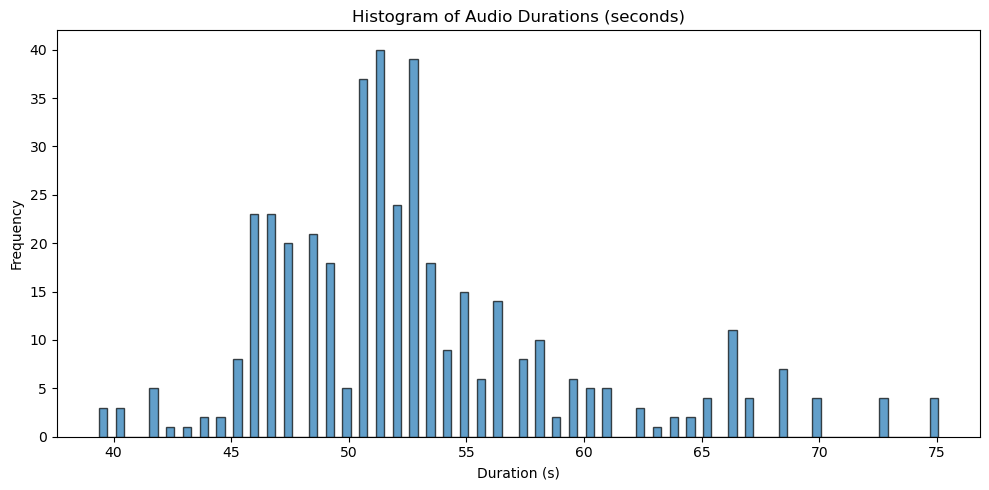

In [31]:
plt.figure(figsize=(10, 5))

plt.hist(durations[durations<100], bins=100, edgecolor='black', alpha=0.7)  # 10 times more bins
plt.title('Histogram of Audio Durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Build Class

In [15]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt
import soundfile as sf

In [18]:


data_cfg = {
    'path': DATA_PATH,
    'sr': 22050,
    'sample_duration':8, # Seconds
    'envelope_detector':{
        'low_pass':800
        },
    'pitch_detector': {
        'n_fft': 4096,
        'hop_length': 1024,
        'fmin': 75,
        'fmax': 800,
        'threshold': 0.15,
        'win_length': None,  # Defaults to n_fft
        'window': 'hann',
        'center': True,
        'pad_mode': 'reflect'
    },
}

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, **config):

        self.data_path = config['path']
        self.sr = config['sr']

        self.envelope_detector_config = config['envelope_detector']
        b, a = butter(N=5, Wn=self.envelope_detector_config['low_pass'] / (0.5 * self.sr), btype='low')
        self.envelope_detector_config['a'] = a
        self.envelope_detector_config['b'] = b

        self.pitch_detector_config = config['pitch_detector']


        self.wav_files = self._get_wav_files()
    
    def _get_wav_files(self):
        wav_files = []

        # Traverse the directory tree
        for root, dirs, files in os.walk(self.data_path):
            
            for file in files:
                if file.endswith('.wav'):
                    wav_files.append(os.path.join(root, file))
        
        return wav_files
    
    def _get_envelope(self, x):
        
        # Apply the filter to the signal
        x_envelope = filtfilt(self.envelope_detector_config['b'], self.envelope_detector_config['a'], x)
        x_envelope = hilbert(x_envelope)
        x_envelope = np.abs(x_envelope)
        return x_envelope
    
    def _get_pitch(self, x):
        x_pitch = librosa.piptrack(x, sr=self.sr, **self.pitch_detector_config)

        return x_pitch

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        wav_path = self.wav_files[idx]
        # waveform, sample_rate = torchaudio.load(wav_path) # Strange torch - numpy incompatibility
        waveform_np, sample_rate = sf.read(wav_path)
        waveform = torch.tensor(waveform_np)

        print(waveform.shape)

        # Resample to self.sr if sample rates differ
        if sample_rate != self.sr:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sr)(waveform)

        # Convert the waveform to a NumPy array for processing
        if waveform_np.shape[0] > 1:
            waveform_np = waveform_np.mean(dim=0)
        
        # Get the envelope and pitch
        x_envelope = self._get_envelope(waveform_np)
        x_pitch = self._get_pitch(waveform_np)
        
        # Apply any optional transformations
        if self.transform:
            waveform = self.transform(waveform)

        # Return a dictionary with the waveform, envelope, and pitch
        return {
            'x': waveform,
            'x_envelope': torch.tensor(x_envelope),
            'x_pitch': torch.tensor(x_pitch)
        }


In [19]:
DATASET = AudioDataset(**data_cfg)

In [20]:
DATASET[0]

torch.Size([2293760])


TypeError: _mean() got an unexpected keyword argument 'dim'

In [9]:
import numpy as np
print(np.__version__)

1.26.4
